# Zero-shot Text Classification

Although SetFit was designed for few-shot learning, the method can also be applied in scenarios where no labeled data is available. The main trick is to create _synthetic examples_ that resemble the classification task, and then train a SetFit model on them.

Remarkably, this simple technique typically outperforms the zero-shot pipeline in 🤗 Transformers, and can generate predictions by a factor of 5x (or more) faster!

In this tutorial, we'll explore how:

* SetFit can be applied for zero-shot classification
* Adding synthetic examples can also provide a performance boost to few-shot classification.

## Setup

If you're running this Notebook on Colab or some other cloud platform, you will need to install the `setfit` library. Uncomment the following cell and run it:

In [1]:
%pip install setfit matplotlib transformers==4.45

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.2/75.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers

To benchmark the performance of the "zero-shot" method, we'll use the following dataset and pretrained model:

In [2]:
dataset_id = "emotion"
model_id = "sentence-transformers/paraphrase-mpnet-base-v2"

Next, we'll download the reference dataset from the Hugging Face Hub:

In [3]:
from datasets import load_dataset

reference_dataset = load_dataset(dataset_id)
reference_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

Now that we're set up, let's create some synthetic data to train on!

## Creating a synthetic dataset

The first thing we need to do is create a dataset of synthetic examples. In `setfit`, we can do this by applying the `get_templated_dataset()` function to a dummy dataset. This function expects a few main things:

* A list of candidate labels to classify with. We'll use the labels from the reference dataset here, but this could be anything that's relevant to the task and dataset at hand.
* A template to generate examples with. By default, it is `"This sentence is {}"`, where the `{}` will be filled by one of the candidate labels
* A sample size $N$, which will create $N$ synthetic examples per class. We find $N=8$ usually works best.

Armed with this information, let's first extract some candidate labels from the dataset:

In [4]:
# Extract ClassLabel feature from "label" column
label_features = reference_dataset["train"].features["label"]
# Label names to classify with
candidate_labels = label_features.names
candidate_labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


<Tip>

Some datasets on the Hugging Face Hub don't have a `ClassLabel` feature for the label column. In these cases, you should compute the candidate labels manually by first computing the id2label mapping as follows:

</Tip>

In [11]:
def get_id2label(dataset):
    # The column with the label names
    label_names = dataset.unique("label_text")
    # The column with the label IDs
    label_ids = dataset.unique("label")
    id2label = dict(zip(label_ids, label_names))
    # Sort by label ID
    return {key: val for key, val in sorted(id2label.items(), key = lambda x: x[0])}

# id2label = get_id2label(reference_dataset["train"])
# candidate_labels = list(id2label.values())

Now that we have the labels, it's a simple matter to create synthetic examples:

In [6]:
from datasets import Dataset
from setfit import get_templated_dataset

# A dummy dataset to fill with synthetic examples
dummy_dataset = Dataset.from_dict({})
train_dataset = get_templated_dataset(dummy_dataset, candidate_labels=candidate_labels, sample_size=8)
train_dataset

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 48
})


<Tip>

You might find you can get better performance by tweaking the `template` argument from the default of `"The sentence is {}"` to variants like `"This sentence is {}"` or `"This example is {}"`.

</Tip>


Since our dataset has 6 classes and we chose a sample size of 8, our synthetic dataset contains $6\times 8=48$ examples. If we take a look at a few of the examples:

In [7]:
train_dataset.shuffle()[:3]

{'text': ['This sentence is love',
  'This sentence is love',
  'This sentence is fear'],
 'label': [2, 2, 4]}


We can see that each input takes the form of the template and has a corresponding label associated with it.

Let's not train a SetFit model on these examples!

## Fine-tuning the model

To train a SetFit model, the first thing to do is download a pretrained checkpoint from the Hub. We can do so by using the `SetFitModel.from_pretrained()` method:

In [8]:
from setfit import SetFitModel

model = SetFitModel.from_pretrained(model_id)

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Here, we've downloaded a pretrained Sentence Transformer from the Hub and added a logistic classification head to the create the SetFit model. As indicated in the message, we need to train this model on some labeled examples. We can do so by using the [Trainer](https://huggingface.co/docs/setfit/main/en/reference/trainer#setfit.Trainer) class as follows:

In [9]:
from setfit import Trainer

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=reference_dataset["test"]
)

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Now that we've created a trainer, we can train it! While we're at it, let's time how long it takes to train and evaluate the model:

In [10]:
%%time
trainer.train()
zeroshot_metrics = trainer.evaluate()
zeroshot_metrics

***** Running training *****
  Num unique pairs = 1920
  Batch size = 16
  Num epochs = 1
/usr/local/lib/python3.10/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
1,0.129700
50,0.020000
100,0.002300


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

***** Running evaluation *****


CPU times: user 21 s, sys: 2.75 s, total: 23.8 s
Wall time: 42.8 s


{'accuracy': 0.542}


Great, now that we have a reference score let's compare against the zero-shot pipeline from 🤗 Transformers.

## Comparing against the zero-shot pipeline from 🤗 Transformers

🤗 Transformers provides a zero-shot pipeline that frames text classification as a natural language inference task. Let's load the pipeline and place it on the GPU for fast inference:

In [36]:
from transformers import pipeline

pipe = pipeline(task="zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


Now that we have the model, let's generate some predictions. We'll use the same candidate labels as we did with SetFit and increase the batch size to speed things up:

In [37]:
%%time
zeroshot_preds = pipe(reference_dataset["test"]["text"], batch_size=16, candidate_labels=candidate_labels)

CPU times: user 1min 48s, sys: 229 ms, total: 1min 48s
Wall time: 1min 53s



Note that this took almost 5x longer to generate predictions than SetFit! OK, so how well does it perform? Since each prediction is a dictionary of label names ranked by score:

In [38]:
zeroshot_preds[0]

{'sequence': 'im feeling rather rotten so im not very ambitious right now',
 'labels': ['sadness', 'anger', 'surprise', 'fear', 'joy', 'love'],
 'scores': [0.7367977499961853,
  0.10041721910238266,
  0.09770206362009048,
  0.05880090966820717,
  0.004266335163265467,
  0.0020156854297965765]}

We can use the `str2int()` function from the `label` column to convert them to integers.

In [16]:
preds = [label_features.str2int(pred["labels"][0]) for pred in zeroshot_preds]

**Note:** As noted earlier, if you're using a dataset that doesn't have a `ClassLabel` feature for the label column, you'll need to compute the label mapping manually with something like:

In [22]:
# id2label = get_id2label(reference_dataset["train"])
# label2id = {v:k for k,v in id2label.items()}
# preds = [label2id[pred["labels"][0]] for pred in zeroshot_preds]

The last step is to compute accuracy using 🤗 Evaluate:

In [23]:
import evaluate

metric = evaluate.load("accuracy")
transformers_metrics = metric.compute(predictions=preds, references=reference_dataset["test"]["label"])
transformers_metrics

{'accuracy': 0.3765}

``{'accuracy': 0.3765}``


Compared to SetFit, this approach performs significantly worse. Let's wrap up our analysis by combining synthetic examples with a few labeled ones.

## Augmenting labeled data with synthetic examples

If you have a few labeled examples, adding synthetic data can often boost performance. To simulate this, let's first sample 8 labeled examples from our reference dataset:

In [24]:
from setfit import sample_dataset

train_dataset = sample_dataset(reference_dataset["train"])
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 48
})

To warm up, we'll train a SetFit model on these true labels:

In [39]:
model = SetFitModel.from_pretrained(model_id)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=reference_dataset["test"]
)
trainer.train()
fewshot_metrics = trainer.evaluate()
fewshot_metrics

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1920
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.223300
50,0.199700
100,0.072200


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

***** Running evaluation *****


{'accuracy': 0.4505}

In [40]:
{'accuracy': 0.4705}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'accuracy': 0.4705}

Note that for this particular dataset, the performance with true labels is _worse_ than training on synthetic examples! In our experiments, we found that the difference depends strongly on the dataset in question. Since SetFit models are fast to train, you can always try both approaches and pick the best one.

In any case, let's now add some synthetic examples to our training set:

In [41]:
augmented_dataset = get_templated_dataset(train_dataset, candidate_labels=candidate_labels, sample_size=8)
augmented_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 96
})

As before, we can train and evaluate SetFit with the augmented dataset:

In [43]:
model = SetFitModel.from_pretrained(model_id)

trainer = Trainer(
    model=model,
    train_dataset=augmented_dataset,
    eval_dataset=reference_dataset["test"]
)
trainer.train()
augmented_metrics = trainer.evaluate()
augmented_metrics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/96 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 7680
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.304700
50,0.185300
100,0.046900
150,0.004500
200,0.002000
250,0.001500
300,0.001300
350,0.001100
400,0.001100
450,0.001000


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

***** Running evaluation *****


{'accuracy': 0.5975}


Great, this has given us a significant boost in performance and given us a few percentage points over the purely synthetic example.

Let's plot the final results for comparison:

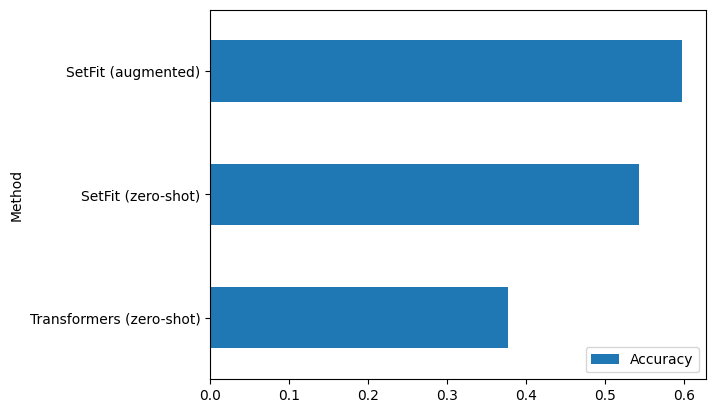

In [44]:
import pandas as pd

df = pd.DataFrame.from_dict({"Method":["Transformers (zero-shot)", "SetFit (zero-shot)", "SetFit (augmented)"], "Accuracy": [transformers_metrics["accuracy"], zeroshot_metrics["accuracy"], augmented_metrics["accuracy"]]})
df.plot(kind="barh", x="Method");